In [90]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
from sklearn import preprocessing
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [91]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [92]:
# Initialize variables required for the algorithm

learning_rate = 2e-2    # initial learning rate
Kx = 10
Ky = 10
#n_hidden = Kx*Ky        # number of hidden units that are displayed in Ky by Kx array
n_hidden = 2000
mu = 0.0                # mean for gaussian distribution to initialize weights with
sigma = 1.0             # standard deviation for gaussian distribution to initialize weights with
n_epochs = 200          # number of epochs
batch_size = 100        # size of the minibatch
precision = 1e-30       # parameter to control numerical precision of weight updates
anti_hebbian_learning_strength = 0.4    # Strength of the anti-hebbian learning
lebesgue_norm = 2.0                     # Lebesgue norm of the weights
rank = 2                                # ranking parameter, must be integer that is bigger or equal than 2

In [93]:
# UNSUPERVISED 'BIO' LEARNING ALGORITHM

# Define function that performs the unsupervised learning and returns weights
# that correspond to feature detectors.
# Uses cuda if available.
def get_unsupervised_weights(data, n_hidden, n_epochs, batch_size, learning_rate, precision, 
                             anti_hebbian_learning_strength, lebesgue_norm, rank):
    print("Starting unsupervised bio-plausible training")
    
    num_samples = data.shape[0]   # Number of samples/images.
    num_features = data.shape[1]  # Number of pixels for each sample/image.
    
    # Initialize weights to be values drawn from gaussian distribution.
    synapses = np.random.normal(mu, sigma, (n_hidden, num_features)).astype(np.float32)
    weights = torch.from_numpy(synapses).to(device)

    # The external loop runs over epochs
    for epoch in range(n_epochs):
        eps = learning_rate * (1 - epoch / n_epochs)
        #print(f'epoch learning rate: {eps}')

        # Scramble the images and values. So that when making a
        # mini batch, random values/images will be chosen on each iteration.
        random_permutation_samples = np.random.permutation(num_samples)
        shuffled_epoch_data = data[random_permutation_samples,:]

        # Internal loop runs over minibatches    
        for i in range(num_samples // batch_size):        
            # For every minibatch the overlap with the data (tot_input) is 
            # calculated for each data point and each hidden unit.
            mini_batch = shuffled_epoch_data[i*batch_size:(i+1)*batch_size,:].astype(np.float32)
            mini_batch = torch.from_numpy(mini_batch).to(device)           
            mini_batch = torch.transpose(mini_batch, 0, 1)

            sign = torch.sign(weights)            
            W = sign * torch.abs(weights) ** (lebesgue_norm - 1)    
            # https://stackoverflow.com/questions/44524901/how-to-do-product-of-matrices-in-pytorch
            tot_input_torch = torch.mm(W, mini_batch)

            # The sorted strengths of the activations are stored in y. 
            # The variable yl stores the activations of the post synaptic cells - 
            # it is denoted by g(Q) in Eq 3 of 'Unsupervised Learning by Competing Hidden Units', see also Eq 9 and Eq 10.        
            y_torch = torch.argsort(tot_input_torch, dim=0)            
            yl_torch = torch.zeros((n_hidden, batch_size), dtype = torch.float).to(device)
            yl_torch[y_torch[n_hidden-1,:], torch.arange(batch_size)] = 1.0
            yl_torch[y_torch[n_hidden-rank], torch.arange(batch_size)] = -anti_hebbian_learning_strength

            # The variable ds is the right hand side of Eq 3        
            xx_torch = torch.sum(yl_torch * tot_input_torch,1)  
            xx_torch = xx_torch.unsqueeze(1)                    
            xx_torch = xx_torch.repeat(1, num_features)
            ds_torch = torch.mm(yl_torch, torch.transpose(mini_batch, 0, 1)) - (xx_torch * weights)

            # Update weights
            # The weights are updated after each minibatch in a way so that the largest update 
            # is equal to the learning rate eps at that epoch.        
            nc_torch = torch.max(torch.abs(ds_torch))
            if nc_torch < precision: 
                nc_torch = precision            
            weights += eps*(ds_torch/nc_torch)

            #if (i+1) % 100 == 0:
            #    print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{num_samples // batch_size}]')

        print (f'Epoch [{epoch+1}/{n_epochs}]')
        
    print("Completed unsupervised bio-plausible training")
    return weights.cpu().numpy()


In [94]:
# LOAD AND PREPARE MNIST DATA

print("Loading MNIST...")
mat = scipy.io.loadmat('mnist_all.mat')
print("Done loading MNIST")
#print(mat)

Nc=10 # number of classes
N=784 # number of pixels for each image. 28x28

M=np.zeros((0,N))
for i in range(Nc):
    M=np.concatenate((M, mat['train'+str(i)]), axis=0)
M=M/255.0

data_mnist = M
print(f'Number of samples: {data_mnist.shape[0]}')
print(f'Number of features: {data_mnist.shape[1]}')

Loading MNIST...
Done loading MNIST
Number of samples: 60000
Number of features: 784


In [ ]:
# LOAD AND PREPARE CIFAR-10 DATA
# REFERENCE: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# Keeping here for reference. From link above.
# As per the 'hidden competing units' paper, no need to Normalize as provided in the link.
# The dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
#transform = transforms.Compose(
#    [transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# The CIFAR-10 dataset has PILImage images of range [0, 1]. 
# As mentioned in the 'hidden competing units' paper, "no preprocessing of the data was used except that
# each input image was normalized to be a unit vector in the 32x32x3 = 3072-dimensional space."
# We transform the images to Tensors here, and normalize to unit vectors further on in this cell.
transform = transforms.Compose([transforms.ToTensor()])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

# This cell uses just the training data loader to initialize the CIFAR-10 dataset as
# a unit vector in the 3072-dimensional space
# TODO re-initialise these loaders when performing supervised training, and when testing.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=25000)
# test_loader = torch.utils.data.DataLoader(test_dataset)

cifar_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Test function to display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display some random training images
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1)
#dataiter = iter(train_loader)
#images, labels = dataiter.next()
#print(images.shape)
#print(labels.shape)
#imshow(torchvision.utils.make_grid(images))

num_classes=10 # number of classes
num_pixels=32*32 # number of pixels for each image. 32x32
num_channels = 3 # RGB
M=np.zeros((0, num_pixels*num_channels)) # Want 3072-dimensional space

# Like for MNIST, ensure M has shape (num_samples, 3072)
# Do in a couple iterations, each handling half of the training data
for i, (images, labels) in enumerate(train_loader):
    images = torch.reshape(images, (25000,-1)).numpy()
    M=np.concatenate((M, images), axis=0)

data = M

# L2-normalize the training samples to unit vectors.
data_cifar = preprocessing.normalize(data, norm='l2')
print(f'CIFAR-10 training data shape: {data_cifar.shape}')
print(f'Number of CIFAR-10 training samples: {data_cifar.shape[0]}')
print(f'Number of CIFAR-10 features: {data_cifar.shape[1]}')


# Test print normalized data
#sample_data = data_cifar[0]
#print(sample_data.shape)
#print("Magnitude of the normalized vector:")
#print(np.linalg.norm(sample_data))
#print(sample_data)
#print(np.amax(data_cifar))
#print(np.amin(data_cifar))


In [ ]:
# LOAD AND PREPARE CIFAR-10 DATA
# REFERENCE: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# Keeping here for reference. From link above.
# As per the 'hidden competing units' paper, no need to Normalize as provided in the link.
# The dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
#transform = transforms.Compose(
#    [transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# The CIFAR-10 dataset has PILImage images of range [0, 1]. 
# As mentioned in the 'hidden competing units' paper, "no preprocessing of the data was used except that
# each input image was normalized to be a unit vector in the 32x32x3 = 3072-dimensional space."
# We transform the images to Tensors here, and normalize to unit vectors further on in this cell.
transform = transforms.Compose([transforms.ToTensor()])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


cifar_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Test function to display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display some random training images
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1)
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)
#imshow(torchvision.utils.make_grid(images))

In [95]:
# RUN UNSUPERVISED 'BIO' LEARNING ALGORITHM for MNIST

# Calculates weights for data and provided number of hidden units (given other configuration)
weights_mnist = get_unsupervised_weights(data_mnist, n_hidden, n_epochs, batch_size, learning_rate, precision, 
                                         anti_hebbian_learning_strength, lebesgue_norm, rank)
print(weights_mnist.shape)
print(weights_mnist)

Starting unsupervised bio-plausible training
Epoch [1/200]
Epoch [2/200]
Epoch [3/200]
Epoch [4/200]
Epoch [5/200]
Epoch [6/200]
Epoch [7/200]
Epoch [8/200]
Epoch [9/200]
Epoch [10/200]
Epoch [11/200]
Epoch [12/200]
Epoch [13/200]
Epoch [14/200]
Epoch [15/200]
Epoch [16/200]
Epoch [17/200]
Epoch [18/200]
Epoch [19/200]
Epoch [20/200]
Epoch [21/200]
Epoch [22/200]
Epoch [23/200]
Epoch [24/200]
Epoch [25/200]
Epoch [26/200]
Epoch [27/200]
Epoch [28/200]
Epoch [29/200]
Epoch [30/200]
Epoch [31/200]
Epoch [32/200]
Epoch [33/200]
Epoch [34/200]
Epoch [35/200]
Epoch [36/200]
Epoch [37/200]
Epoch [38/200]
Epoch [39/200]
Epoch [40/200]
Epoch [41/200]
Epoch [42/200]
Epoch [43/200]
Epoch [44/200]
Epoch [45/200]
Epoch [46/200]
Epoch [47/200]
Epoch [48/200]
Epoch [49/200]
Epoch [50/200]
Epoch [51/200]
Epoch [52/200]
Epoch [53/200]
Epoch [54/200]
Epoch [55/200]
Epoch [56/200]
Epoch [57/200]
Epoch [58/200]
Epoch [59/200]
Epoch [60/200]
Epoch [61/200]
Epoch [62/200]
Epoch [63/200]
Epoch [64/200]
Epoc

In [ ]:
# RUN UNSUPERVISED 'BIO' LEARNING ALGORITHM for CIFAR

# Calculates weights for data and provided number of hidden units (given other configuration)
weights_cifar = get_unsupervised_weights(data_cifar, n_hidden, n_epochs, batch_size, learning_rate, precision, 
                                         anti_hebbian_learning_strength, lebesgue_norm, rank)
print(weights_cifar.shape)
print(weights_cifar)

<IPython.core.display.Javascript object>


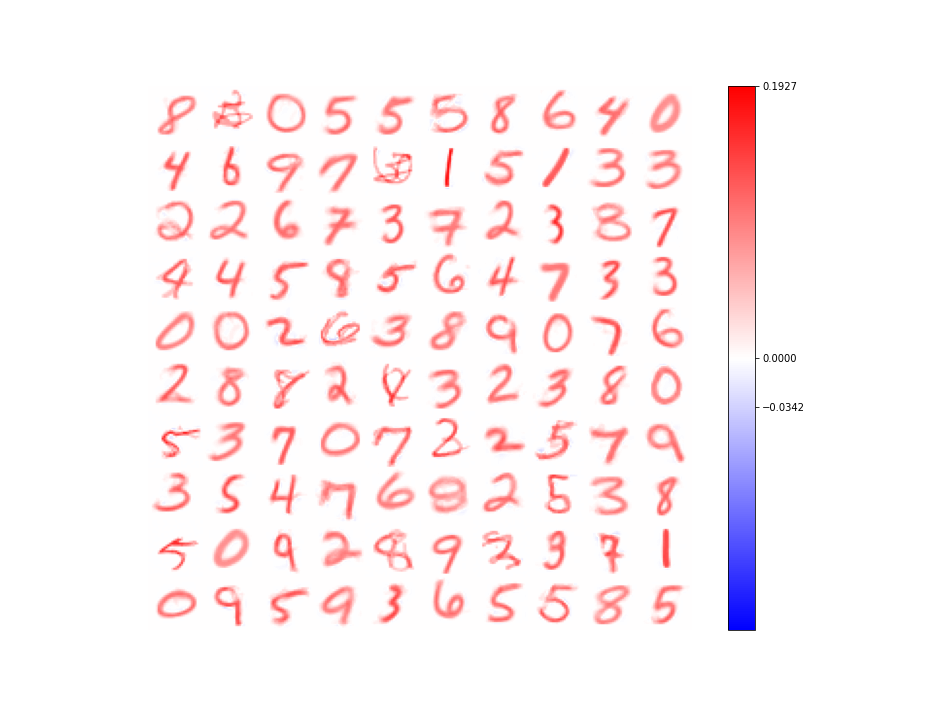

(2000, 784)
[[ 8.3388691e-35  1.4443746e-34 -1.1806889e-34 ... -1.0295553e-35
  -3.8752611e-35  8.1301787e-35]
 [-4.2303455e-08  6.5667351e-08 -2.5521751e-07 ... -2.4454664e-07
  -1.6930732e-08 -1.9321091e-08]
 [ 2.8025969e-45  2.8025969e-45 -2.8025969e-45 ...  2.8025969e-45
  -2.8025969e-45 -2.8025969e-45]
 ...
 [ 2.8025969e-45 -2.8025969e-45 -2.8025969e-45 ...  2.8025969e-45
   2.8025969e-45  2.8025969e-45]
 [ 1.2611686e-44 -1.1210388e-44 -1.2611686e-44 ... -1.2611686e-44
  -1.2611686e-44 -1.2611686e-44]
 [ 3.1894255e-22  1.3369439e-21 -1.1513763e-22 ...  1.4170463e-21
   1.2964639e-23  1.0531024e-21]]
(280, 280)
####
(280, 280)
[[ 8.33886911e-35  1.44437456e-34 -1.18068891e-34 ... -1.40129846e-45
   1.40129846e-45  1.40129846e-45]
 [-1.29148488e-34  3.92922848e-35  4.61367155e-35 ... -1.40129846e-45
  -1.40129846e-45 -1.40129846e-45]
 [ 1.17756330e-35 -4.34081336e-35  2.51981850e-35 ...  1.40129846e-45
   1.40129846e-45 -1.40129846e-45]
 ...
 [ 4.20389539e-45  4.20389539e-45 -4.2038

In [96]:
# Draw MNIST weights/feature detectors generated by unsupervised bio algo

# REFERENCED FROM: https://github.com/DimaKrotov/Biological_Learning
# To draw a heatmap of the weights a helper function is created

def draw_weights(synapses, Kx, Ky):
    print(synapses.shape) # (100, 784)
    print(synapses)
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    print(HM.shape) # (280, 280)
    for y in range(Ky):
        for x in range(Kx):
            
            shit = synapses[yy,:]
            shit_reshape = synapses[yy,:].reshape(28,28)
            
            #print(synapses.shape)     # (100, 784)
            #print(shit.shape)         # (784,)
            #print(shit_reshape.shape) # (28, 28)
            
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            
            #print(HM.shape)
            
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    print("####")
    print(HM.shape)
    print(HM)
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw() 

%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))
#draw_weights(weights, Kx, Ky)
draw_weights(weights_mnist, Kx, Ky)
print(weights_mnist.shape)
print("Fin")

In [ ]:
# Draw CIFAR-10 weights/feature detectors generated by unsupervised bio algo

def draw_weights(synapses, Kx, Ky):
    print(synapses)
    print(synapses.shape) # (100, 3072)
    yy=0
    HM=np.zeros((32*Ky,32*Kx,3))
    print(HM.shape) # (320, 320, 3)
    for y in range(Ky):
        for x in range(Kx):

            shit = synapses[yy,:]
            shit_reshape = synapses[yy,:].reshape(3,32,32)

            #print(synapses.shape)   # (100, 3072)
            #print(shit.shape)          # (3072,)
            #print(shit_reshape.shape)  # (3, 32, 32)

            #HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            HM[y*32:(y+1)*32,x*32:(x+1)*32,:]=synapses[yy,:].reshape(32,32,3)

            #HM[z, y*32:(y+1)*32,x*32:(x+1)*32]=synapses[yy,:].reshape(3,32,32)
            yy += 1
    print("Done with the fucking loop")
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM[:,:,0],cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()

%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))
draw_weights(weights_cifar, Kx, Ky)
print("Fin")

In [ ]:
# USE THIS BLOCK FOR DEBUGGING PURPOSES ONLY !!

# Contains data loading and whole bio learning in one block of code.
# Plots the feature detectors at the end of training.

# LOAD AND PREPARE DATA

print("Loading MNIST...")
mat = scipy.io.loadmat('mnist_all.mat')
print("Done loading MNIST")

Nc=10 # output nodes
N=784 # number of pixels for each image. 28x28

M=np.zeros((0,N))
for i in range(Nc):
    M=np.concatenate((M, mat['train'+str(i)]), axis=0)
M=M/255.0

data = M
num_samples = data.shape[0]   # 60000 training and validation examples. Number of samples
num_features = data.shape[1]  # number of pixels for each image. 28x28. Also: num_samples, num_pixels..

# ------------------------------------------------------------------------------------------------------------

# UNSUPERVISED 'BIO' LEARNING ALGORITHM

# Initialize weights to be values drawn from gaussian distribution.
synapses = np.random.normal(mu, sigma, (n_hidden, N)).astype(np.float32)
weights = torch.from_numpy(synapses).to(device)

# The external loop runs over epochs
for epoch in range(n_epochs):
    eps = learning_rate * (1 - epoch / n_epochs)
    #print(f'epoch learning rate: {eps}')
    
    # Scramble the images and values. So that when making a
    # mini batch, random values/images will be chosen on each iteration.
    random_permutation_samples = np.random.permutation(num_samples)
    shuffled_epoch_data = data[random_permutation_samples,:]
    
    # Internal loop runs over minibatches    
    for i in range(num_samples // batch_size):        
        # For every minibatch the overlap with the data (tot_input) is 
        # calculated for each data point and each hidden unit.
        mini_batch = shuffled_epoch_data[i*batch_size:(i+1)*batch_size,:].astype(np.float32)
        mini_batch = torch.from_numpy(mini_batch).to(device)           
        mini_batch = torch.transpose(mini_batch, 0, 1)
        
        sign = torch.sign(weights)            
        W = sign * torch.abs(weights) ** (lebesgue_norm - 1)    
        # https://stackoverflow.com/questions/44524901/how-to-do-product-of-matrices-in-pytorch
        tot_input_torch = torch.mm(W, mini_batch)
                
        # The sorted strengths of the activations are stored in y. 
        # The variable yl stores the activations of the post synaptic cells - 
        # it is denoted by g(Q) in Eq 3 of 'Unsupervised Learning by Competing Hidden Units', see also Eq 9 and Eq 10.        
        y_torch = torch.argsort(tot_input_torch, dim=0)            
        yl_torch = torch.zeros((n_hidden, batch_size), dtype = torch.float).to(device)
        yl_torch[y_torch[n_hidden-1,:], torch.arange(batch_size)] = 1.0
        yl_torch[y_torch[n_hidden-rank], torch.arange(batch_size)] = -anti_hebbian_learning_strength
        
        # The variable ds is the right hand side of Eq 3        
        xx_torch = torch.sum(yl_torch * tot_input_torch,1)  
        xx_torch = xx_torch.unsqueeze(1)                    
        xx_torch = xx_torch.repeat(1, num_features)
        ds_torch = torch.mm(yl_torch, torch.transpose(mini_batch, 0, 1)) - (xx_torch * weights)
        
        # Update weights
        # The weights are updated after each minibatch in a way so that the largest update 
        # is equal to the learning rate eps at that epoch.        
        nc_torch = torch.max(torch.abs(ds_torch))
        if nc_torch < precision: 
            nc_torch = precision            
        weights += eps*(ds_torch/nc_torch)
        
        #if (i+1) % 100 == 0:
        #    print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{num_samples // batch_size}]')
        
    print (f'Epoch [{epoch+1}/{n_epochs}]')
    #draw_weights(weights.numpy(), Kx, Ky)

%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))
draw_weights(weights.cpu().numpy(), Kx, Ky)
print("Fin")

In [97]:
# Supervised part of bio learning algorithm
# Use weights obtained from unsupervised component
# REFERENCE: https://picnet.com.au/blog/pytorch-implementation-of-unsupervised-learning-by-competing-hidden-units-mnist-classifier/

# Describe model
class BioClassifier(nn.Module):
    # W is the unsupervised pretrained weight matrix of shape: (n_filters, img_sz)
    def __init__(self, W, out_features, n=10, beta=.01):
        super().__init__()
        #print(W.shape)  # (2000, 784)
        
        wtf = W.transpose(1, 0) # (img_sz, n_filters)
        #print(wtf.shape)  # (2000, 784)
        
        # This line below is incorrect because it does not perform the transpose to get the desired shape in comments.
        # Changed it to be correct.
        # self.W = W.transpose(0, 1) # (img_sz, n_filters)
        #self.W = W.transpose(1, 0) # (img_sz, n_filters)
        self.W = torch.from_numpy(W.transpose(1, 0)).to(device) # (img_sz, n_filters)
        #print(self.W.shape)
        self.n = n
        self.beta = beta
        #print(W.size)
        #print(W.shape[0])
        
        # This line below is incorrect because .size(0) written by the author is completely nonsensical.
        # Changed it to be correct.
        #self.S = nn.Linear(W.size(0), out_features, bias=False)
        self.S = nn.Linear(W.shape[0], out_features, bias=False)
        
    def forward(self, v): # v: (batch_sz, img_sz)
        #print(self.W)
        #print(self.W.shape)
        Wv = torch.matmul(v, self.W)
        
        # Author again makes a mistake in not specifiying 'F'
        #h = F.relu(Wv) ** self.n
        h = nn.functional.relu(Wv) ** self.n
        Sh = self.S(h) # Sₐᵤhᵤ == Sh
        c = torch.tanh(self.beta * Sh)
        return c


In [98]:
# Loss function for supervised part of biological network
# REFERENCE: https://picnet.com.au/blog/pytorch-implementation-of-unsupervised-learning-by-competing-hidden-units-mnist-classifier/

class BioLoss(nn.Module):
    def __init__(self, out_features, m=6):
        super().__init__()
        self.out_features = out_features
        self.m = m

    def forward(self, c, t): 
        t_ohe = torch.eye(self.out_features, dtype=torch.float, device='cuda')[t]
        t_ohe[t_ohe==0] = -1.
        loss = (c - t_ohe).abs() ** self.m
        return loss.sum()
    
    # According to the hidden units paper, c = predictions, t = actual labels
    def loss(self, c, t): 
        #print("In BioLoss.loss")
        #print(f'self.out_features: {self.out_features}')
        #print(f'c.shape: {c.shape}')
        #print(f't.shape: {t.shape}')
        #print(c)
        #print(t)
        
        t_ohe = torch.eye(self.out_features, dtype=torch.float, device='cuda')[t]
        #print(f't_ohe.shape: {t_ohe.shape}')
        #print(t_ohe)
        
        t_ohe[t_ohe==0] = -1.
        #print(t_ohe)
        
        loss = (c - t_ohe).abs() ** self.m
        return loss.sum()
    

In [99]:
# 0) Prepare data
# MNIST dataset 
print("Downloading MNIST data...")
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("Completed downloading MNIST data.")

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
examples = iter(test_loader)
example_data, example_targets = examples.next()

# Plot some sample data for sanity check
#%matplotlib inline
#%matplotlib notebook
#for i in range(6):
#    plt.subplot(2,3,i+1)
#    plt.imshow(example_data[i][0], cmap='gray')
#plt.show()


# 1) Design and init model
model = BioClassifier(weights_mnist, 10).to(device)

# Print the named parameters to test that model initialised correctly. 
# Names parameter that requires grad should be only S.weight.
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)


# 2) Construct loss and optimizer
criterion = BioLoss(10)
supervised_learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=supervised_learning_rate) 

# 3) Train the model - training loop

n_total_steps = len(train_loader)
print(f'n_total_steps: {n_total_steps}')

print('Start training...')
#for epoch in range(n_epochs):  # TODO have different number of epochs for the supervised part of training
for epoch in range(10):
    print()
    print(f'epoch: {epoch}')
    for i, (images, labels) in enumerate(train_loader):
        
        #print(i)
        #print(images.shape)
        #print(labels.shape)
        
        # origin images shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        #print(images.shape)
        #print(labels.shape)
        #print()
        
        
        # predict = forward pass
        outputs = model(images)
        #print(f'outputs: {outputs}')

        # calculate loss
        loss = criterion.loss(outputs, labels)
        #print(f'loss: {loss}')

        # backward pass to calculate gradients
        optimizer.zero_grad() # TODO do this here or at the end of the loop?
        loss.backward()

        # update weights
        optimizer.step()

        # zero autograd .grad after updating
        # TODO here or before calling loss.backward?
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Completed training.')

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Completed downloading MNIST data.
S.weight tensor([[ 9.9622e-04,  1.9039e-02,  8.9387e-03,  ...,  1.6579e-02,
         -1.2521e-02,  2.2554e-03],
        [ 5.9291e-03,  2.1286e-03, -9.5623e-03,  ...,  2.0602e-02,
         -2.0101e-02, -2.8927e-03],
        [-2.4768e-03, -1.5097e-02,  2.7472e-04,  ...,  7.5051e-03,
          1.6343e-02,  6.3646e-03],
        ...,
        [-1.1499e-02,  2.1590e-02, -2.3771e-03,  ..., -1.5056e-02,
         -8.1790e-03, -3.2138e-03],
        [ 1.7942e-02, -9.4230e-04,  4.9023e-05,  ...,  1.1217e-02,
          9.8013e-03,  1.5859e-02],
        [-7.4641e-03,  1.4729e-02, -2.1034e-02,  ..., -2.0924e-02,
          5.7327e-03, -1.1717e-02]], device='cuda:0')
n_total_steps: 600
Start training...

epoch: 0
Epoch [1/200], Step [100/600], Loss: 6400.0000
Epoch [1/200], Step [200/600], Loss: 6400.0000
Epoch [1/200], Step [300/600], Loss: 8510.4736
Epoch [1/200], Step [400/600], Loss: 6016.0000
Epoch [1/200], Step [500/600], Loss: 6208.0000
Epoch [1/200], Step [600/6